In [1]:
import os
import numpy as np
import pandas as pd
import gzip
import matplotlib.pyplot as plt
from datetime import timedelta
from script import days_in_month, hours_in_day
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
DIR_SENTIMENT = "/srv/data/twitter_sentiment/"
DIR_GEOGRAPHY = "/srv/data/twitter_geography/"
DIR_STORE = "./store/"
DIR_OUTPUT = "./output"

In [35]:
def get_daily_num_post_and_sentiment_and_missing_file(year, month, day):
    """

    @param year:
    @param month:
    @param day:
    @return:
    1) result_df: Pandas dataframe, a dataframe that includes the following columns: year, month, day, country, state, city, num_posts, avg_sent_score
    2) missing_files: a list of str, file names that do not exist
    3) empty_files: a list of str, files names that are empty
    4) file_name_to_num_post: dict, maps file names to number of posts in that file
    """
    date = "".join([str(year), "_", str(month), "_", str(day).zfill(2)])
    result_df = None # sentiment score and num post dataframe

    # num_post and sentiment result
    num_posts_by_city = pd.DataFrame() # pd dataframe to represent number of posts by city

    # missing data result
    missing_files = []
    empty_files = []
    
    # getting file name to num post map for corrupt files later
    file_name_to_num_post = dict()

    for hour in range(0, 24):
        has_error = False
        try:
            file_name = ''.join([DIR_GEOGRAPHY, str(year), "/" "geography_", date, "_", str(hour).zfill(2), ".csv.gz"])
            with gzip.open(file_name) as f:
                geo_posts = pd.read_csv(f, sep="\t")
                file_name_to_num_post[file_name] = len(geo_posts)
        except FileNotFoundError:
            print(file_name, "does not exist.")
            missing_files.append(file_name)
            has_error = True
        except pd.errors.EmptyDataError:
            print(file_name, "is empty.")
            empty_files.append(file_name)
            has_error = True
        try:
            file_name = ''.join([DIR_SENTIMENT, str(year), "/", "bert_sentiment_", date, "_", str(hour).zfill(2), ".csv.gz"])
            with gzip.open(file_name) as f:
                sent_posts = pd.read_csv(f, sep="\t")
                file_name_to_num_post[file_name] = len(sent_posts)
        except FileNotFoundError:
            print(file_name, "does not exist.")
            missing_files.append(file_name)
            has_error = True
        except pd.errors.EmptyDataError:
            print(file_name, "is empty.")
            empty_files.append(file_name)
            has_error = True
            
        if has_error:
            continue

        common_posts = pd.merge(geo_posts, sent_posts, on="message_id", how="inner")

        common_posts["COUNTRY_STATE_CITY"] = common_posts['NAME_0'].astype(str) + '_' + common_posts['NAME_1'].astype(
            str) + '_' + common_posts['NAME_2']

        # num posts calculation
        num_posts_by_city_this_hour = common_posts.groupby(["COUNTRY_STATE_CITY"]).size().to_frame().transpose()
        num_posts_by_city = pd.concat([num_posts_by_city, num_posts_by_city_this_hour], join="outer",
                                         sort=True)

        city_result = common_posts.groupby(["COUNTRY_STATE_CITY"]).agg(
            {"score": np.sum, "message_id": len}).reset_index()
        city_result.rename(columns={"COUNTRY_STATE_CITY": "city", "score": "total_score", "message_id": "num_posts"},
                           inplace=True)
        if result_df is None:
            result_df = city_result
        else:
            result_df = result_df.merge(city_result, on="city", how="outer", suffixes=('_x', '_y'))
            result_df["total_score"] = result_df["total_score_x"].fillna(0) + result_df["total_score_y"].fillna(0)
            result_df["num_posts"] = result_df["num_posts_x"].fillna(0) + result_df["num_posts_y"].fillna(0)
            result_df.drop(columns=["total_score_x", "total_score_y", "num_posts_x", "num_posts_y"], inplace=True)

    if result_df is None:
        result_data = pd.DataFrame()
    else:
        result_df["year"] = [year] * len(result_df)
        result_df["month"] = [month] * len(result_df)
        result_df["day"] = [day] * len(result_df)
        result_df["num_posts"] = result_df["num_posts"].astype(int)
        result_df["country"] = result_df["city"].apply(lambda x: x.split("_")[0])
        result_df["state"] = result_df["city"].apply(lambda x: "_".join(x.split("_")[0:2]))
        result_df["daily_avg_score"] = result_df["total_score"] / result_df["num_posts"]
        result_df.drop(columns=["total_score"], inplace=True)
        column_names = ["year", "month", "day", "country", "state", "city", "num_posts", "daily_avg_score"]
        result_df = result_df[column_names]

    return result_df, missing_files, empty_files, file_name_to_num_post

In [ ]:
get_daily_num_post_and_sentiment_and_missing_file(2012, 1, 1)

In [37]:
def some_method(year):
    missing_files = []
    empty_files = []
    result_df = pd.DataFrame()
    file_name_to_num_post = dict()
    for month in range(1, 2):
        for day in range(1, 3):
            day_df, day_missing_files, day_empty_files, day_file_name_to_num_post = get_daily_num_post_and_sentiment_and_missing_file(year, month, day)
            missing_files = missing_files + day_missing_files
            empty_files = empty_files + day_empty_files
            result_df = pd.concat([result_df, day_df], ignore_index=True)
            file_name_to_num_post.update(day_file_name_to_num_post)
            
    bottom_10_percentile = pd.Series(data=list(file_name_to_num_post.values())).quantile(0.1)
    print(list(file_name_to_num_post.values()))
    print(bottom_10_percentile)
    threshold = min(10000, bottom_10_percentile)
    
    corrupted_files = []
    for file_name in file_name_to_num_post.keys():
        if file_name_to_num_post[file_name] < threshold:
            print("yeet")
            corrupted_files.append(file_name)
    return result_df, missing_files, empty_files, corrupted_files
            

In [43]:
df, b, c, d = some_method(2012)
df

[6, 6, 10, 10, 16, 16, 9, 9, 7, 8, 16, 16, 23, 24, 811, 849, 685, 722, 587, 627, 569, 626, 564, 612, 555, 597, 608, 655, 768, 812, 782, 832, 826, 866, 869, 918, 986, 1041, 894, 934, 885, 934, 931, 976, 1003, 1039, 938, 969, 946, 964, 908, 939, 992, 1022, 903, 945, 914, 936, 855, 883, 772, 796, 740, 774, 609, 657, 576, 618, 578, 625, 569, 616, 642, 692, 723, 795, 714, 783, 798, 834, 927, 978, 934, 977, 947, 990, 1004, 1055, 1027, 1070, 1055, 1098, 1039, 1075, 1074, 1118]
16.0
yeet
yeet
yeet
yeet
yeet
yeet
yeet
yeet


,year,month,day,country,state,city,num_posts,daily_avg_score
0,2012,1,1,Mexico,Mexico_Yucatán,Mexico_Yucatán_Mérida,11,0.604736
1,2012,1,1,United Kingdom,United Kingdom_England,United Kingdom_England_West Yorkshire,67,0.630392
2,2012,1,1,United States,United States_California,United States_California_Los Angeles,205,0.606662
3,2012,1,1,United States,United States_Maryland,United States_Maryland_Howard,15,0.706429
4,2012,1,1,United States,United States_Maryland,United States_Maryland_Montgomery,23,0.459497
...,...,...,...,...,...,...,...,...
7733,2012,1,2,United States,United States_Wisconsin,United States_Wisconsin_Oconto,1,0.051756
7734,2012,1,2,United States,United States_Wisconsin,United States_Wisconsin_Racine,1,0.597721
7735,2012,1,2,United States,United States_Wisconsin,United States_Wisconsin_Trempealeau,1,0.314560
7736,2012,1,2,United States,United States_Wisconsin,United States_Wisconsin_Walworth,1,0.824642


In [42]:
d

['/srv/data/twitter_geography/2012/geography_2012_1_01_00.csv.gz',
 '/srv/data/twitter_sentiment/2012/bert_sentiment_2012_1_01_00.csv.gz',
 '/srv/data/twitter_geography/2012/geography_2012_1_01_01.csv.gz',
 '/srv/data/twitter_sentiment/2012/bert_sentiment_2012_1_01_01.csv.gz',
 '/srv/data/twitter_geography/2012/geography_2012_1_01_03.csv.gz',
 '/srv/data/twitter_sentiment/2012/bert_sentiment_2012_1_01_03.csv.gz',
 '/srv/data/twitter_geography/2012/geography_2012_1_01_04.csv.gz',
 '/srv/data/twitter_sentiment/2012/bert_sentiment_2012_1_01_04.csv.gz']

In [ ]:
d

In [17]:
c

[]

In [8]:
bottom_10_percentile = a.groupby(by=["year", "month", "day"]).sum()["num_posts"].quantile(0.1)
threshold = min(10000, bottom_10_percentile)
threshold

10000

In [18]:
hi = {"a": 1, "b": 10, "c": 100, "d": 1000}
list(hi.values())

[1, 10, 100, 1000]

In [21]:
os.listdir(DIR_GEOGRAPHY)

['2017',
 '2018',
 '2012',
 '2015',
 '2021',
 '2016',
 '2019',
 '2014',
 '2020',
 '2013']

In [23]:
a

,year,month,day,country,state,city,num_posts,daily_avg_score
0,2012,1,1,Mexico,Mexico_Yucatán,Mexico_Yucatán_Mérida,11,0.604736
1,2012,1,1,United Kingdom,United Kingdom_England,United Kingdom_England_West Yorkshire,67,0.630392
2,2012,1,1,United States,United States_California,United States_California_Los Angeles,205,0.606662
3,2012,1,1,United States,United States_Maryland,United States_Maryland_Howard,15,0.706429
4,2012,1,1,United States,United States_Maryland,United States_Maryland_Montgomery,23,0.459497
...,...,...,...,...,...,...,...,...
7733,2012,1,2,United States,United States_Wisconsin,United States_Wisconsin_Oconto,1,0.051756
7734,2012,1,2,United States,United States_Wisconsin,United States_Wisconsin_Racine,1,0.597721
7735,2012,1,2,United States,United States_Wisconsin,United States_Wisconsin_Trempealeau,1,0.314560
7736,2012,1,2,United States,United States_Wisconsin,United States_Wisconsin_Walworth,1,0.824642


In [24]:
area_level = "country"
area = "United States"

In [32]:
area_summed_df = a.groupby(["year", "month", "day", area_level]).sum()
area_summed_df

num_posts  daily_avg_score
year month day country                                         
2012 1     1   Algeria                       1         0.880810
               Angola                        1         0.615514
               Argentina                    36        15.939242
               Australia                    93        45.821051
               Austria                      19         7.844764
...                                        ...              ...
           2   Uruguay                       8         2.558097
               Venezuela                    35        15.188034
               Vietnam                       3         2.248103
               Virgin Islands, U.S.          8         2.395199
               Zambia                        3         1.777419

[196 rows x 2 columns]

In [40]:
area_summed_df.reset_index(inplace=True)

In [42]:
area_summed_df[area_summed_df[area_level] == area]

,year,month,day,country,num_posts,daily_avg_score
90,2012,1,1,United States,5623,560.215113
190,2012,1,2,United States,9346,705.676217


In [48]:
haha = area_summed_df[area_summed_df[area_level] == area].reset_index()["num_posts"]
haha

0    5623
1    9346
Name: num_posts, dtype: int64

Text(0.5, 1.0, 'Number of Posts by Day in United States, 2012')

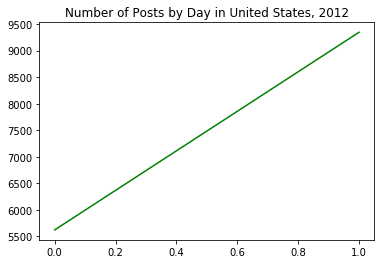

In [58]:
plt.ticklabel_format(axis='y', style='sci')

plt.plot([0, 1], haha, color='green', label="Common Posts")
plt.title("".join(["Number of Posts by Day in ", area, ", ", str(2012)]))

In [60]:
summed_df = a.groupby(["year", "month", "day"]).sum()
summed_df.reset_index(inplace=True)
summed_df

,year,month,day,num_posts,daily_avg_score
0,2012,1,1,13311,2125.640093
1,2012,1,2,20202,2481.582424


In [62]:
temp = a
temp

,year,month,day,country,state,city,num_posts,daily_avg_score
0,2012,1,1,Mexico,Mexico_Yucatán,Mexico_Yucatán_Mérida,11,0.604736
1,2012,1,1,United Kingdom,United Kingdom_England,United Kingdom_England_West Yorkshire,67,0.630392
2,2012,1,1,United States,United States_California,United States_California_Los Angeles,205,0.606662
3,2012,1,1,United States,United States_Maryland,United States_Maryland_Howard,15,0.706429
4,2012,1,1,United States,United States_Maryland,United States_Maryland_Montgomery,23,0.459497
...,...,...,...,...,...,...,...,...
7733,2012,1,2,United States,United States_Wisconsin,United States_Wisconsin_Oconto,1,0.051756
7734,2012,1,2,United States,United States_Wisconsin,United States_Wisconsin_Racine,1,0.597721
7735,2012,1,2,United States,United States_Wisconsin,United States_Wisconsin_Trempealeau,1,0.314560
7736,2012,1,2,United States,United States_Wisconsin,United States_Wisconsin_Walworth,1,0.824642


In [63]:
temp["daily_total_score"] = temp["num_posts"] * temp["daily_avg_score"]

In [64]:
temp

,year,month,day,country,state,city,num_posts,daily_avg_score,daily_total_score
0,2012,1,1,Mexico,Mexico_Yucatán,Mexico_Yucatán_Mérida,11,0.604736,6.652095
1,2012,1,1,United Kingdom,United Kingdom_England,United Kingdom_England_West Yorkshire,67,0.630392,42.236272
2,2012,1,1,United States,United States_California,United States_California_Los Angeles,205,0.606662,124.365774
3,2012,1,1,United States,United States_Maryland,United States_Maryland_Howard,15,0.706429,10.596433
4,2012,1,1,United States,United States_Maryland,United States_Maryland_Montgomery,23,0.459497,10.568441
...,...,...,...,...,...,...,...,...,...
7733,2012,1,2,United States,United States_Wisconsin,United States_Wisconsin_Oconto,1,0.051756,0.051756
7734,2012,1,2,United States,United States_Wisconsin,United States_Wisconsin_Racine,1,0.597721,0.597721
7735,2012,1,2,United States,United States_Wisconsin,United States_Wisconsin_Trempealeau,1,0.314560,0.314560
7736,2012,1,2,United States,United States_Wisconsin,United States_Wisconsin_Walworth,1,0.824642,0.824642


In [68]:
sdf = temp.groupby(["year", "month", "day"]).sum()

In [69]:
sdf.reset_index(inplace=True)

In [73]:
sdf["daily_avg_score"] = sdf["daily_total_score"] / sdf["num_posts"]

In [72]:
sdf["num_posts"] = [13311, 0]
sdf

,year,month,day,num_posts,daily_avg_score,daily_total_score
0,2012,1,1,13311,0.598955,7972.690147
1,2012,1,2,0,0.583234,11782.502279


In [74]:
sdf

,year,month,day,num_posts,daily_avg_score,daily_total_score
0,2012,1,1,13311,0.598955,7972.690147
1,2012,1,2,0,inf,11782.502279


In [75]:
sdf.loc[~np.isfinite(sdf['daily_avg_score']), 'daily_avg_score'] = np.nan

In [76]:
sdf

,year,month,day,num_posts,daily_avg_score,daily_total_score
0,2012,1,1,13311,0.598955,7972.690147
1,2012,1,2,0,NaN,11782.502279


In [92]:
data = np.array([[2012, 1, 10, 0, np.nan]])
k = pd.DataFrame(data=data, columns=["year", "month", "day", "num_posts", "daily_avg_score"])

In [93]:
k

,year,month,day,num_posts,daily_avg_score
0,2012.0,1.0,10.0,0.0,NaN


In [8]:
year = 2012
corrupted_files = pd.read_csv("".join(["../output/missing_file_report/", "corrupted_files_", str(year), "_geography.csv"]))

In [9]:
corrupted_files

,Unnamed: 0,corrupted_files
0,0,/srv/data/twitter_geography/2012/geography_201...
1,1,/srv/data/twitter_geography/2012/geography_201...
2,2,/srv/data/twitter_geography/2012/geography_201...
3,3,/srv/data/twitter_geography/2012/geography_201...
4,4,/srv/data/twitter_geography/2012/geography_201...
...,...,...
702,702,/srv/data/twitter_geography/2012/geography_201...
703,703,/srv/data/twitter_geography/2012/geography_201...
704,704,/srv/data/twitter_geography/2012/geography_201...
705,705,/srv/data/twitter_geography/2012/geography_201...


In [10]:
corrupted_files.drop(columns="Unnamed: 0", inplace=True)

In [17]:
corrupted_files

,corrupted_files,dates
0,/srv/data/twitter_geography/2012/geography_201...,1_01_00
1,/srv/data/twitter_geography/2012/geography_201...,1_01_01
2,/srv/data/twitter_geography/2012/geography_201...,1_01_03
3,/srv/data/twitter_geography/2012/geography_201...,1_01_04
4,/srv/data/twitter_geography/2012/geography_201...,2_09_11
...,...,...
703,/srv/data/twitter_geography/2012/geography_201...,11_19_16
704,/srv/data/twitter_geography/2012/geography_201...,11_19_17
705,/srv/data/twitter_geography/2012/geography_201...,11_19_18
706,/srv/data/twitter_geography/2012/geography_201...,11_19_19


In [16]:
corrupted_files.loc[707] = ["/srv/data/twitter_sentiment/2012/bert_sentiment_2012_1_03.csv", 0] 

In [28]:
def get_date(file_name, is_geo):
    if is_geo == True:
        return "_".join(file_name.split("/")[5].split(".")[0].split("_")[1:4])
    else:
        return "_".join(file_name.split("/")[5].split(".")[0].split("_")[2:5])

In [30]:
corrupted_files['dates'] = np.where(corrupted_files["corrupted_files"].str.contains("geography"), corrupted_files['corrupted_files'].apply(lambda x: get_date(x, True)), corrupted_files['corrupted_files'].apply(lambda x: get_date(x, False)))




In [31]:
corrupted_files

,corrupted_files,dates
0,/srv/data/twitter_geography/2012/geography_201...,2012_1_01
1,/srv/data/twitter_geography/2012/geography_201...,2012_1_01
2,/srv/data/twitter_geography/2012/geography_201...,2012_1_01
3,/srv/data/twitter_geography/2012/geography_201...,2012_1_01
4,/srv/data/twitter_geography/2012/geography_201...,2012_2_09
...,...,...
703,/srv/data/twitter_geography/2012/geography_201...,2012_11_19
704,/srv/data/twitter_geography/2012/geography_201...,2012_11_19
705,/srv/data/twitter_geography/2012/geography_201...,2012_11_19
706,/srv/data/twitter_geography/2012/geography_201...,2012_11_19


In [29]:
file_name = "/srv/data/twitter_geography/2012/geography_2012_1_01_00_hihi.csv"

get_date("/srv/data/twitter_geography/2012/geography_2012_1_01_00_hihi.csv", True)

'2012_1_01'

In [27]:
"_".join(file_name.split("/")[5].split(".")[0].split("_")[1:4])

'2012_1_01'

In [34]:
set(corrupted_files['dates'].unique())

{'2012_10_12',
 '2012_10_15',
 '2012_10_17',
 '2012_10_20',
 '2012_10_25',
 '2012_10_26',
 '2012_10_30',
 '2012_10_31',
 '2012_11_02',
 '2012_11_05',
 '2012_11_06',
 '2012_11_07',
 '2012_11_08',
 '2012_11_09',
 '2012_11_10',
 '2012_11_11',
 '2012_11_12',
 '2012_11_13',
 '2012_11_14',
 '2012_11_15',
 '2012_11_16',
 '2012_11_17',
 '2012_11_18',
 '2012_11_19',
 '2012_1_01',
 '2012_1_03',
 '2012_2_09',
 '2012_2_23',
 '2012_3_27',
 '2012_4_01',
 '2012_4_02',
 '2012_4_03',
 '2012_4_04',
 '2012_4_05',
 '2012_4_06',
 '2012_4_07',
 '2012_4_08',
 '2012_4_09',
 '2012_4_10',
 '2012_4_11',
 '2012_4_12',
 '2012_4_13',
 '2012_4_14',
 '2012_4_15',
 '2012_4_16',
 '2012_4_17',
 '2012_4_18',
 '2012_4_19',
 '2012_4_20',
 '2012_4_21',
 '2012_4_22',
 '2012_4_23',
 '2012_4_24',
 '2012_4_25',
 '2012_4_26',
 '2012_4_27',
 '2012_4_28',
 '2012_4_29',
 '2012_4_30',
 '2012_5_01',
 '2012_5_03',
 '2012_5_08',
 '2012_5_15',
 '2012_5_17',
 '2012_6_30',
 '2012_7_01',
 '2012_8_25',
 '2012_8_28',
 '2012_9_09',
 '2012_9_1

In [40]:
a = pd.Series([1, 2, 3])

a.append(pd.Series([np.nan]*2))

a

0    1
1    2
2    3
dtype: int64